In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import unicodedata
from bisect import bisect_right
from datetime import datetime
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\2747588937.py:2: DtypeWarning: Columns (12,15,16,17,18,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tennis_data_2001_2025.csv')


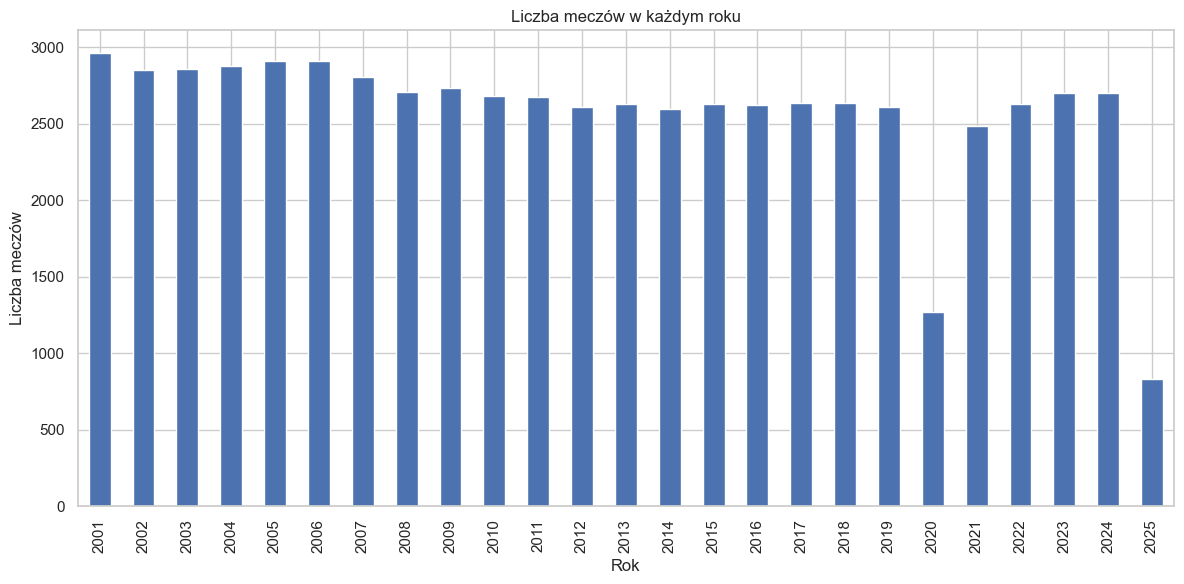

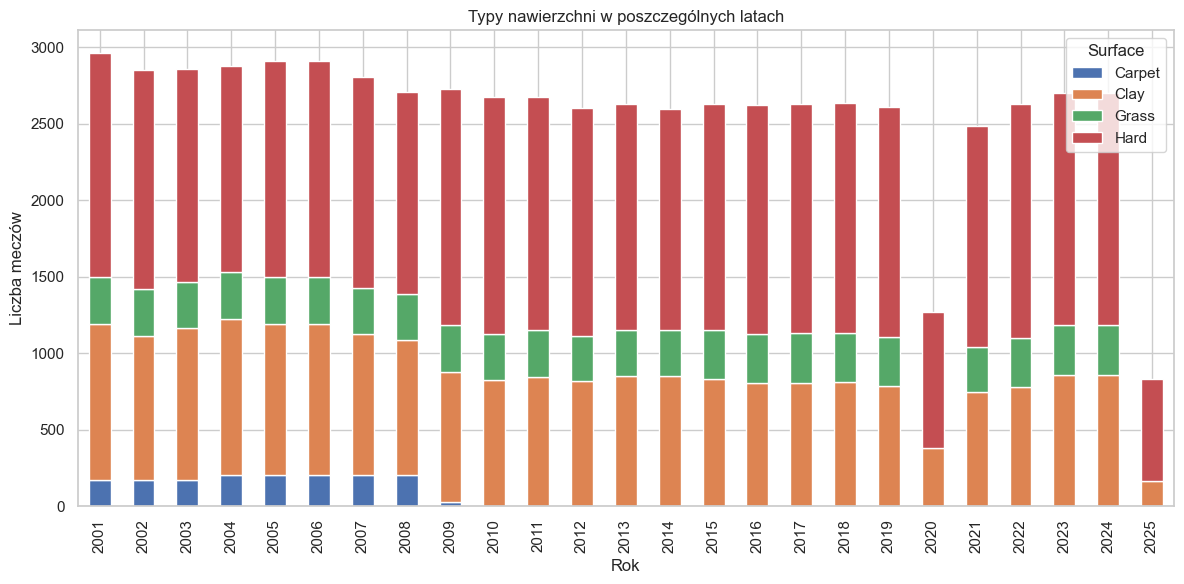

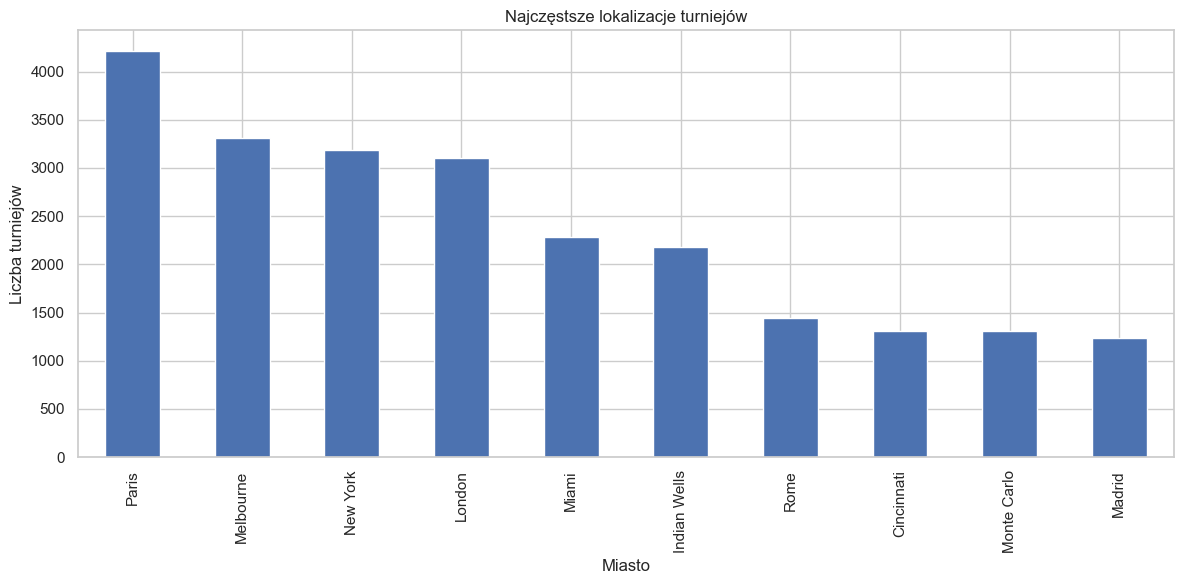

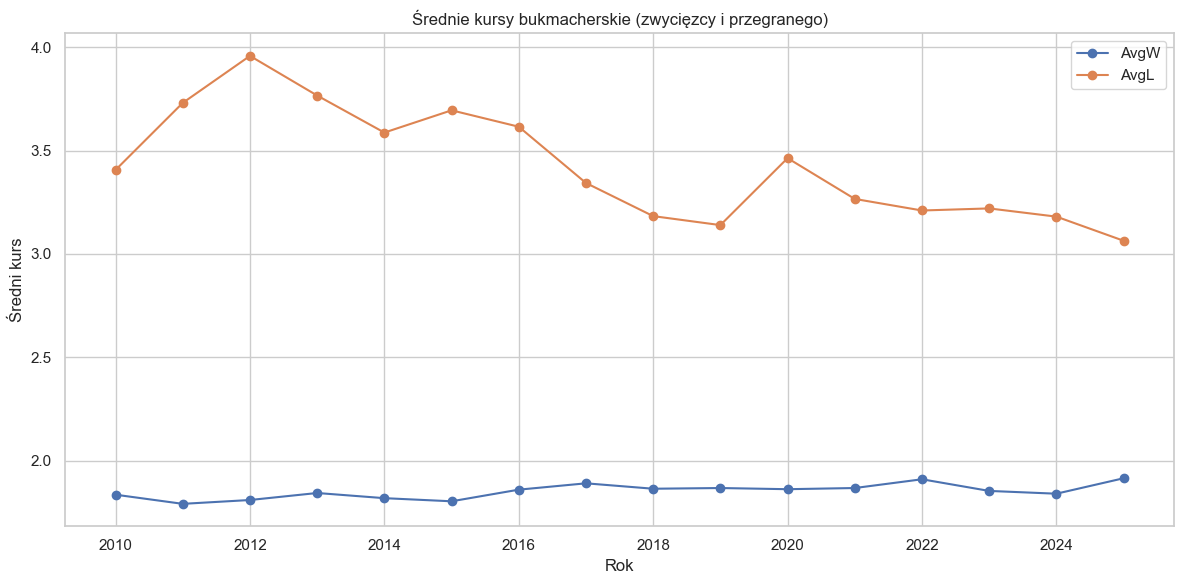

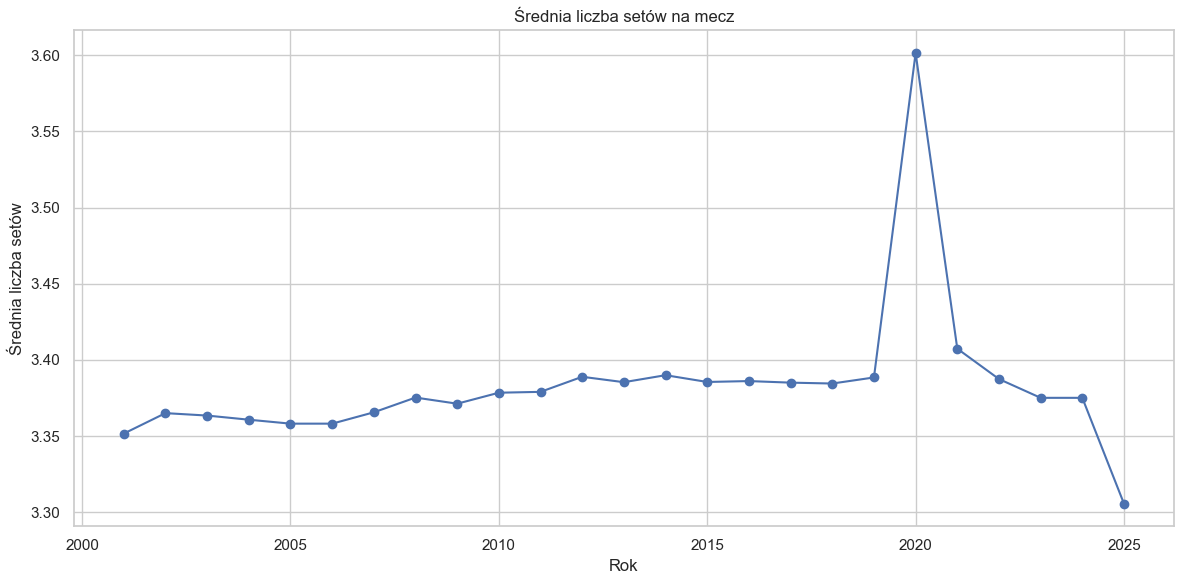

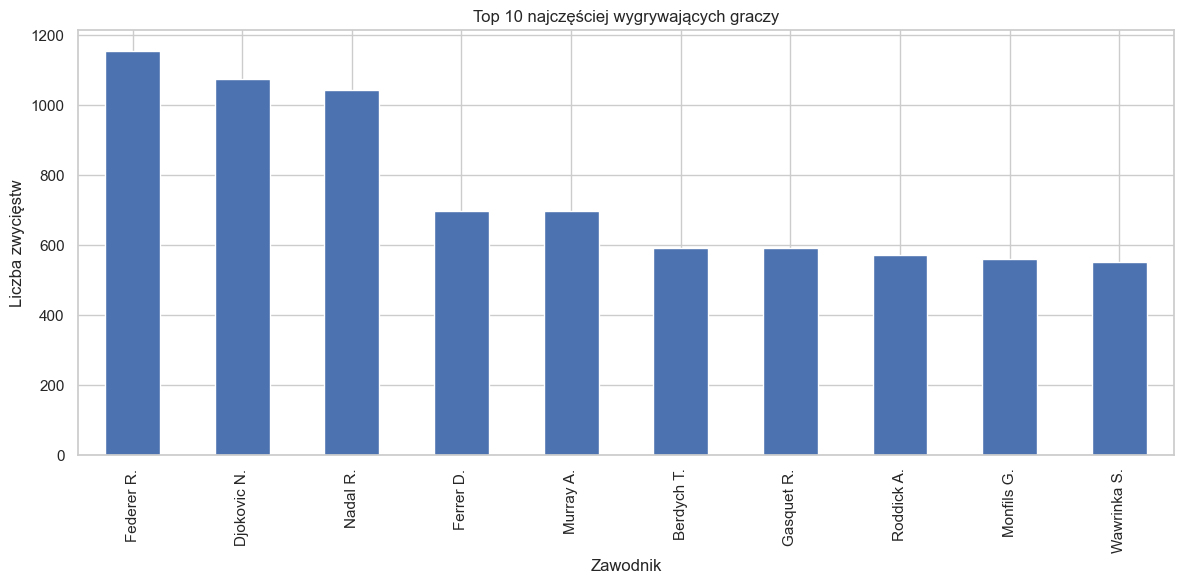

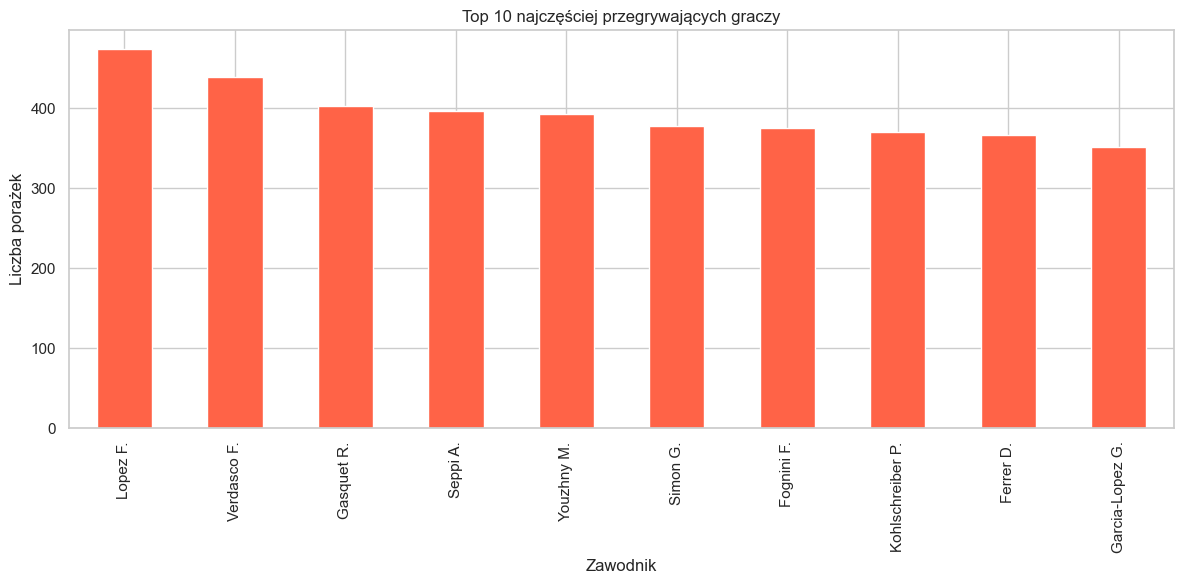

In [6]:
# Wczytanie danych
df = pd.read_csv('tennis_data_2001_2025.csv')

# Ustawienia ogólne
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Liczba meczów w każdym roku
df['Year'] = df['Year'].astype(int)
matches_per_year = df['Year'].value_counts().sort_index()

matches_per_year.plot(kind='bar')
plt.title('Liczba meczów w każdym roku')
plt.xlabel('Rok')
plt.ylabel('Liczba meczów')
plt.tight_layout()
plt.show()

# 2. Typy nawierzchni w poszczególnych latach
surface_year = df.groupby(['Year', 'Surface']).size().unstack().fillna(0)
surface_year.plot(kind='bar', stacked=True)
plt.title('Typy nawierzchni w poszczególnych latach')
plt.xlabel('Rok')
plt.ylabel('Liczba meczów')
plt.tight_layout()
plt.show()

# 3. Najczęstsze lokalizacje turniejów
top_locations = df['Location'].value_counts().head(10)
top_locations.plot(kind='bar')
plt.title('Najczęstsze lokalizacje turniejów')
plt.xlabel('Miasto')
plt.ylabel('Liczba turniejów')
plt.tight_layout()
plt.show()

# 4. Średnie kursy bukmacherskie (zwycięzca vs przegrany)
avg_odds = df.groupby('Year')[['AvgW', 'AvgL']].mean()
avg_odds.plot(marker='o')
plt.title('Średnie kursy bukmacherskie (zwycięzcy i przegranego)')
plt.xlabel('Rok')
plt.ylabel('Średni kurs')
plt.tight_layout()
plt.show()

# 5. Średnia liczba setów (Best of) w każdym roku
best_of_mean = df.groupby('Year')['Best of'].mean()
best_of_mean.plot(marker='o')
plt.title('Średnia liczba setów na mecz')
plt.xlabel('Rok')
plt.ylabel('Średnia liczba setów')
plt.tight_layout()
plt.show()

# 6. Top 10 zwycięzców
top_winners = df['Winner'].value_counts().head(10)
top_winners.plot(kind='bar')
plt.title('Top 10 najczęściej wygrywających graczy')
plt.xlabel('Zawodnik')
plt.ylabel('Liczba zwycięstw')
plt.tight_layout()
plt.show()

# 7. Top 10 przegranych
top_losers = df['Loser'].value_counts().head(10)
top_losers.plot(kind='bar', color='tomato')
plt.title('Top 10 najczęściej przegrywających graczy')
plt.xlabel('Zawodnik')
plt.ylabel('Liczba porażek')
plt.tight_layout()
plt.show()


In [28]:
# Wczytaj historię, jeśli już wygenerowana
elo = pd.read_csv("elo_history_2001_2025.csv", parse_dates=["Date"])

# Wszystkie wpisy dla Djokovicia
djoko_history = elo[elo["Player"] == "Djokovic N."]

# Sprawdź zakres dat
print("📅 Daty Djokovicia w historii Elo:")
print(djoko_history["Date"].min(), "→", djoko_history["Date"].max())

# Policz liczbę wpisów na rok
djoko_years = djoko_history["Date"].dt.year.value_counts().sort_index()
print("\n📈 Liczba wpisów dla każdego roku:")
print(djoko_years)


📅 Daty Djokovicia w historii Elo:
2004-07-20 00:00:00 → 2025-03-31 00:00:00

📈 Liczba wpisów dla każdego roku:
Date
2004     4
2005    18
2006    52
2007    84
2008    73
2009    95
2010    74
2011    78
2012    81
2013    76
2014    73
2016    72
2024     1
2025    16
Name: count, dtype: int64


In [61]:
# === Wczytanie i przygotowanie danych ===
df = pd.read_excel("dataset/tennis_data_2001_2025_FIXED.xlsx")

# Naprawa dat
df["Date_raw"] = df["Date"]  # backup
df["Date"] = pd.to_datetime(df["Date"].astype(str), errors="coerce")
df["Date"].head()
df[df["Date"]>pd.Timestamp("2017-01-01")].head()



,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,Date_raw
63739,1,Brisbane,Brisbane International,2024-12-29,ATP250,Outdoor,Hard,1st Round,3.0,Vukic A.,...,NaN,NaN,NaN,NaN,NaN,2.14,1.83,2.03,1.78,2024-12-29 00:00:00
63740,1,Brisbane,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3.0,Michelsen A.,...,NaN,NaN,NaN,NaN,NaN,1.48,2.90,1.43,2.74,2024-12-30 00:00:00
63741,1,Brisbane,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3.0,Bonzi B.,...,NaN,NaN,NaN,NaN,NaN,1.73,2.25,1.67,2.18,2024-12-30 00:00:00
63742,1,Brisbane,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3.0,Nishioka Y.,...,NaN,NaN,NaN,NaN,NaN,1.65,2.50,1.59,2.36,2024-12-30 00:00:00
63743,1,Brisbane,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3.0,Thompson J.,...,NaN,NaN,NaN,NaN,NaN,2.63,1.60,2.48,1.54,2024-12-30 00:00:00


In [ ]:
# Lista unikalnych wariantów nazw zawierających "Djokovic"
players_with_djokovic = df[df["Winner"].str.contains("Djokovic", case=False, na=False)]["Winner"].unique()
print(players_with_djokovic)
df[df["Winner"] == "Djokovic N."]["Year"].value_counts().sort_index()
winners = df[df["Winner"].str.contains("Djokovic", na=False)]["Winner"].unique()
for name in winners:
    print(f"'{name}' -> len: {len(name)} | repr: {repr(name)}")


# === 1. Normalizacja znaku + unicode ===
def normalize_name(name):
    if pd.isna(name):
        return ""
    name = str(name)
    name = unicodedata.normalize("NFKC", name)  # Unicode standaryzacja
    name = name.replace('\u00A0', ' ')  # NBSP -> spacja
    name = name.replace('\u202f', ' ')  # wąska spacja
    name = name.replace('\u200b', '')  # zero-width space
    return name.strip()

# === 2. Zamiana formatu imienia na "Nazwisko I." ===
def standardize_format(name):
    parts = name.split()
    if len(parts) >= 2:
        nazwisko = parts[0]
        inicjal = parts[1][0] if parts[1] else ''
        return f"{nazwisko} {inicjal}."
    return name  # jeśli coś poszło nie tak

# === 3. Połączenie funkcji ===
def clean_and_format(name):
    name = normalize_name(name)
    return standardize_format(name)

# === 4. Zastosowanie do danych ===
df["Winner"] = df["Winner"].apply(clean_and_format)
df["Loser"] = df["Loser"].apply(clean_and_format)




['Djokovic N.']
'Djokovic N.' -> len: 11 | repr: 'Djokovic N.'


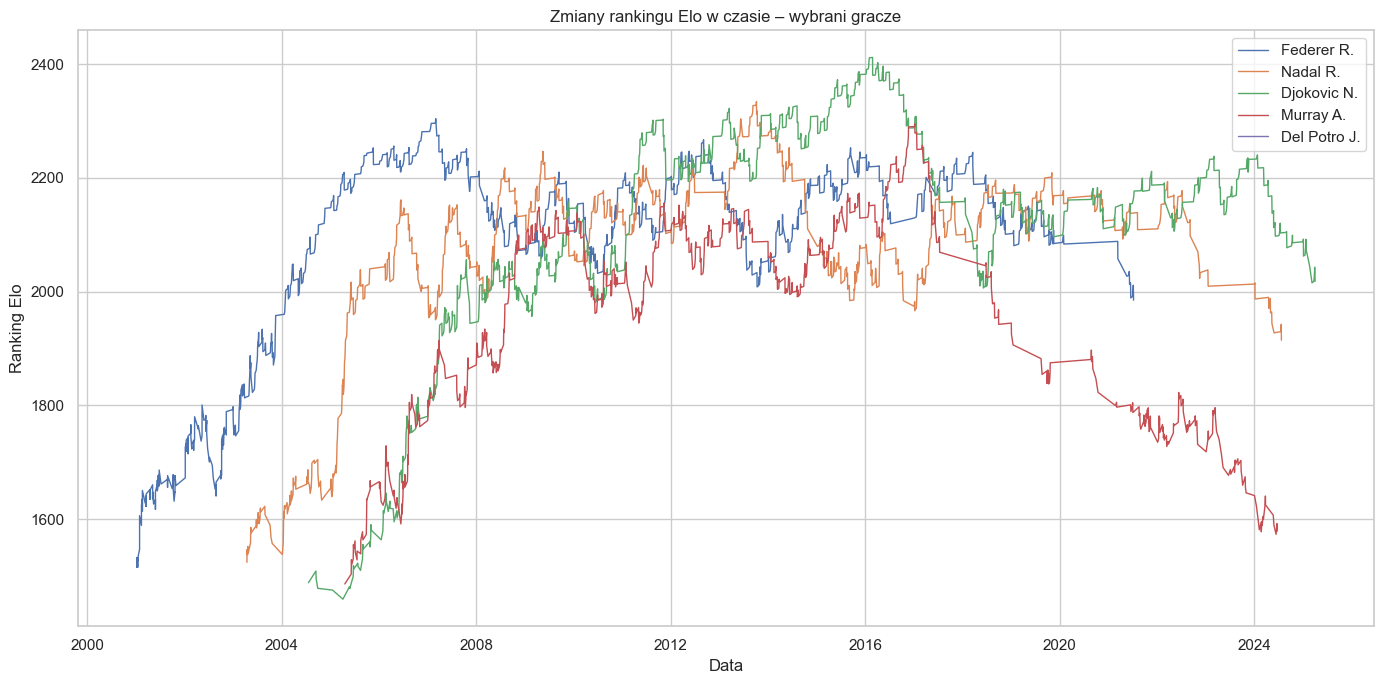

In [66]:
# === 1. Wczytanie danych ===
df = pd.read_excel("dataset/tennis_data_2001_2025_FIXED.xlsx")

# === 2. Naprawa i ujednolicenie dat ===
df["Date_raw"] = df["Date"]  # kopia oryginalnych dat
df["Date"] = df["Date"].astype(str)
df["Date"] = df["Date"].str.extract(r"(\d{4}-\d{2}-\d{2})")[0]
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# === 3. Naprawa kolumny Year ===
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# === 4. Czyszczenie nazwisk zawodników ===
def normalize_name(name):
    if pd.isna(name):
        return ""
    name = str(name)
    name = unicodedata.normalize("NFKC", name)
    name = name.replace('\u00A0', ' ').replace('\u202f', ' ').replace('\u200b', '')
    return name.strip()

def standardize_format(name):
    parts = name.split()
    if len(parts) >= 2:
        surname = parts[0]
        initial = parts[1][0] if parts[1] else ''
        return f"{surname} {initial}."
    return name

def clean_and_format(name):
    return standardize_format(normalize_name(name))

df["Winner"] = df["Winner"].apply(clean_and_format)
df["Loser"] = df["Loser"].apply(clean_and_format)

# === 5. Usunięcie braków w kluczowych danych ===
df = df.dropna(subset=["Date", "Winner", "Loser"])

# === 6. Liczenie Elo dla każdego zawodnika ===
K = 32
initial_rating = 1500
ratings = defaultdict(lambda: initial_rating)
history = []

df = df.sort_values("Date")

def expected_score(rA, rB):
    return 1 / (1 + 10 ** ((rB - rA) / 400))

for _, row in df.iterrows():
    winner = row["Winner"]
    loser = row["Loser"]
    date = row["Date"]

    r_w = ratings[winner]
    r_l = ratings[loser]

    e_w = expected_score(r_w, r_l)
    e_l = expected_score(r_l, r_w)

    ratings[winner] += K * (1 - e_w)
    ratings[loser] += K * (0 - e_l)

    history.append({"Date": date, "Player": winner, "Rating": ratings[winner]})
    history.append({"Date": date, "Player": loser, "Rating": ratings[loser]})

# === 7. Zapis historii Elo do pliku ===
elo_history = pd.DataFrame(history)
elo_history["Date"] = pd.to_datetime(elo_history["Date"], errors="coerce")  # upewnij się, że datetime
elo_history.to_csv("elo_history_2001_2025.csv", index=False)

# === 8. (Opcjonalnie) Wykres wybranych graczy ===
selected_players = ["Federer R.", "Nadal R.", "Djokovic N.", "Murray A.", "Del Potro J."]

plt.figure(figsize=(14, 7))
for player in selected_players:
    player_data = elo_history[elo_history["Player"] == player]
    plt.plot(player_data["Date"], player_data["Rating"], label=player, linewidth=1)

plt.title("Zmiany rankingu Elo w czasie – wybrani gracze")
plt.xlabel("Data")
plt.ylabel("Ranking Elo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("elo_ranking_plot.png")
plt.show()

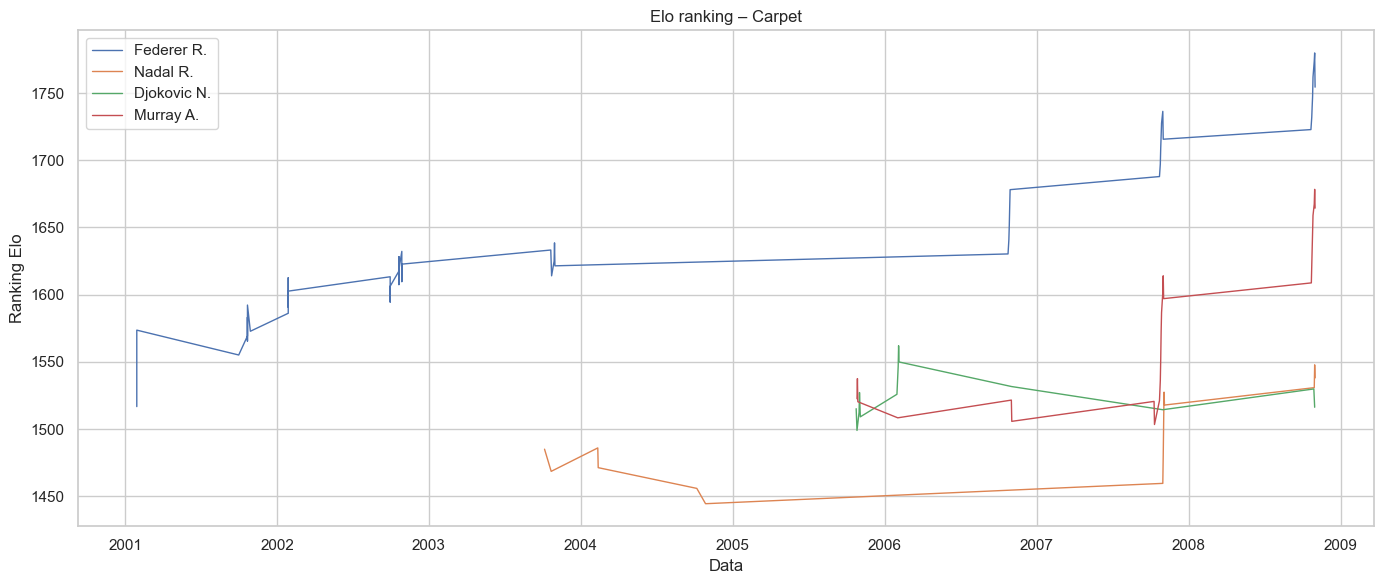

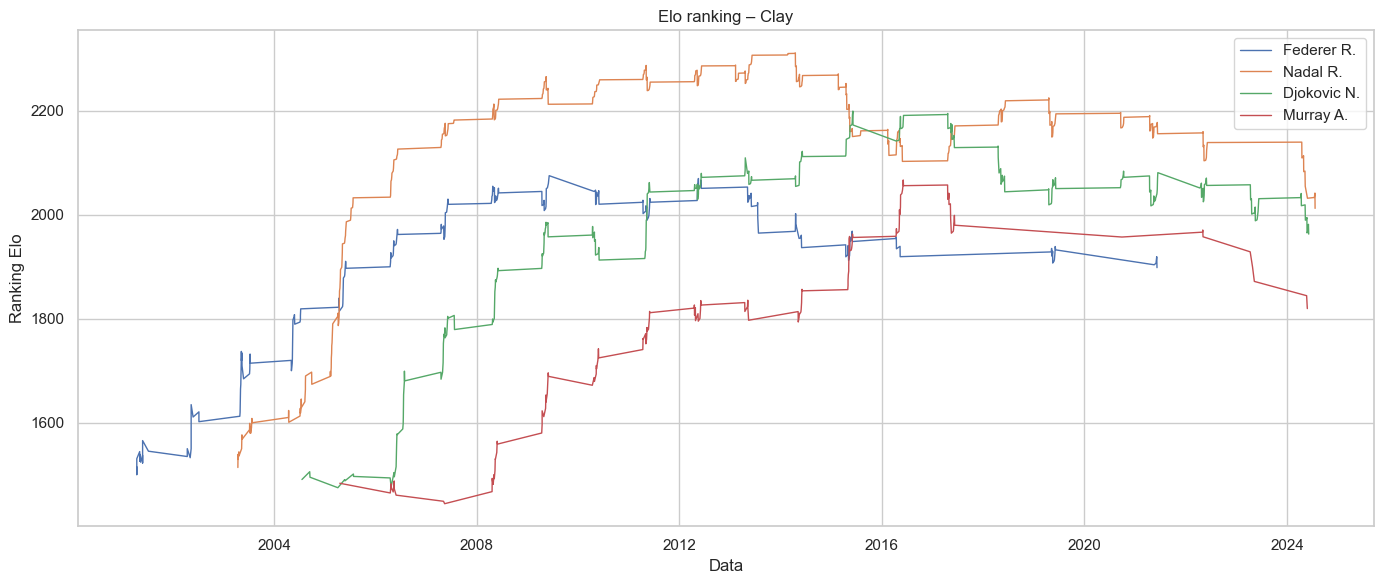

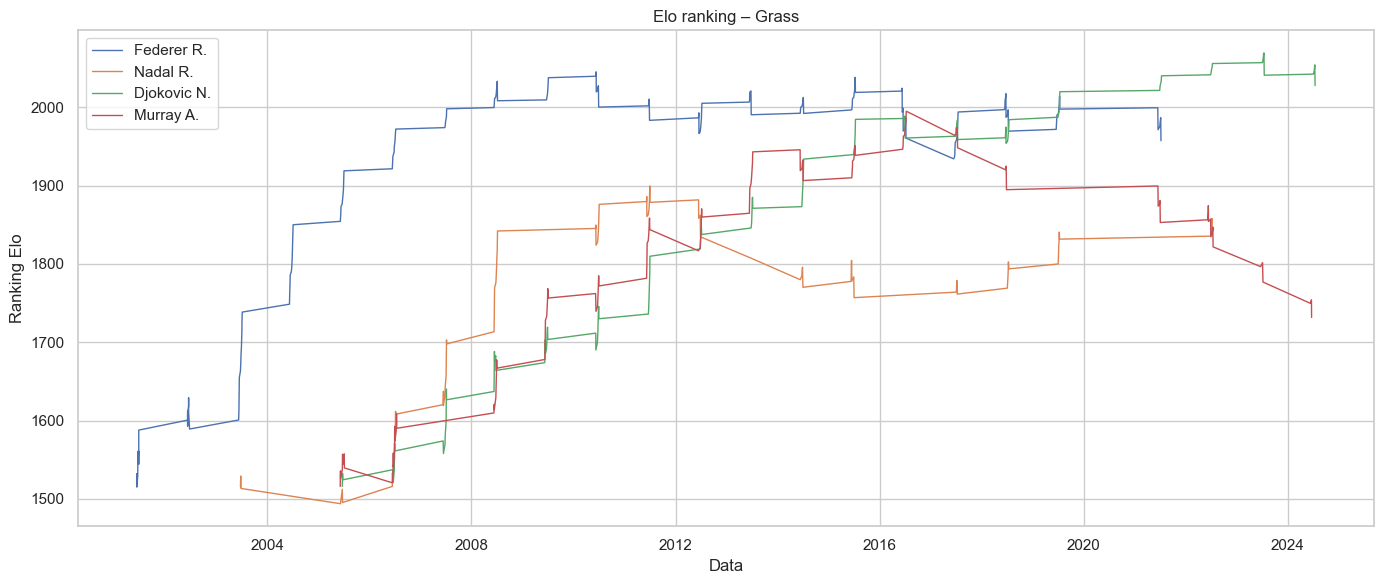

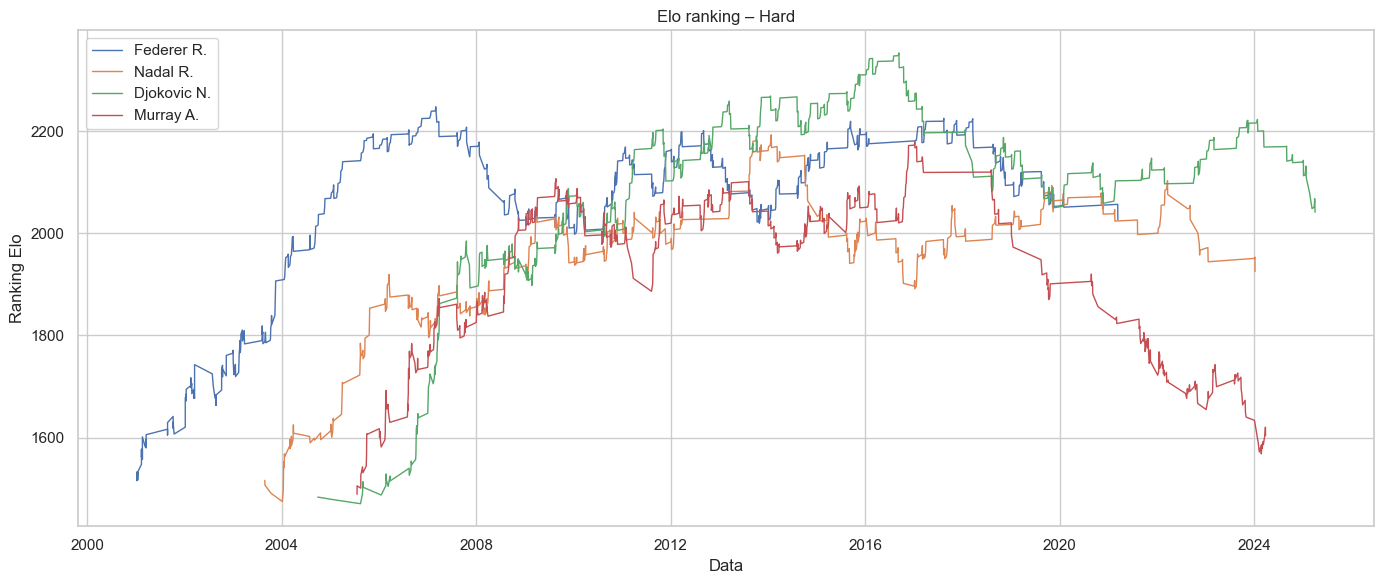

In [67]:
# === 1. Wczytanie danych ===
df = pd.read_excel("dataset/tennis_data_2001_2025_FIXED.xlsx")

# === 2. Naprawa i ujednolicenie dat ===
df["Date_raw"] = df["Date"]
df["Date"] = df["Date"].astype(str).str.extract(r"(\d{4}-\d{2}-\d{2})")[0]
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# === 3. Naprawa kolumny Year ===
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# === 4. Czyszczenie nazwisk zawodników ===
def normalize_name(name):
    if pd.isna(name):
        return ""
    name = str(name)
    name = unicodedata.normalize("NFKC", name)
    name = name.replace('\u00A0', ' ').replace('\u202f', ' ').replace('\u200b', '')
    return name.strip()

def standardize_format(name):
    parts = name.split()
    if len(parts) >= 2:
        surname = parts[0]
        initial = parts[1][0] if parts[1] else ''
        return f"{surname} {initial}."
    return name

def clean_and_format(name):
    return standardize_format(normalize_name(name))

df["Winner"] = df["Winner"].apply(clean_and_format)
df["Loser"] = df["Loser"].apply(clean_and_format)

# === 5. Usunięcie braków w kluczowych danych ===
df = df.dropna(subset=["Date", "Winner", "Loser", "Surface"])

# === 6. Liczenie Elo dla każdej nawierzchni osobno ===
K = 32
initial_rating = 1500
elo_history_surface = []

for surface in df["Surface"].unique():
    surface_df = df[df["Surface"] == surface].sort_values("Date")
    ratings = defaultdict(lambda: initial_rating)
    
    for _, row in surface_df.iterrows():
        winner = row["Winner"]
        loser = row["Loser"]
        date = row["Date"]

        r_w = ratings[winner]
        r_l = ratings[loser]

        e_w = 1 / (1 + 10 ** ((r_l - r_w) / 400))
        e_l = 1 / (1 + 10 ** ((r_w - r_l) / 400))

        ratings[winner] += K * (1 - e_w)
        ratings[loser] += K * (0 - e_l)

        elo_history_surface.append({
            "Date": date,
            "Player": winner,
            "Rating": ratings[winner],
            "Surface": surface
        })
        elo_history_surface.append({
            "Date": date,
            "Player": loser,
            "Rating": ratings[loser],
            "Surface": surface
        })

# === 7. Tworzenie i zapis historii Elo z nawierzchniami ===
elo_df_surface = pd.DataFrame(elo_history_surface)
elo_df_surface.sort_values(["Surface", "Player", "Date"], inplace=True)
elo_df_surface.to_csv("elo_history_by_surface.csv", index=False)

# === 8. Wykres wybranych graczy na różnych nawierzchniach ===
selected_players = ["Federer R.", "Nadal R.", "Djokovic N.", "Murray A.", "Del Potro J."]

for surface in elo_df_surface["Surface"].unique():
    plt.figure(figsize=(14, 6))
    for player in selected_players:
        player_data = elo_df_surface[(elo_df_surface["Player"] == player) & (elo_df_surface["Surface"] == surface)]
        if not player_data.empty:
            plt.plot(player_data["Date"], player_data["Rating"], label=player, linewidth=1)

    plt.title(f"Elo ranking – {surface}")
    plt.xlabel("Data")
    plt.ylabel("Ranking Elo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"elo_surface_{surface}.png")
    plt.show()

In [3]:

# === 1. Wczytanie danych ===
elo_overall = pd.read_csv("elo_history_2001_2025.csv", parse_dates=["Date"])
elo_surface = pd.read_csv("elo_history_by_surface.csv", parse_dates=["Date"])
matches = pd.read_excel("dataset/tennis_data_2001_2025_FIXED.xlsx")

# === 2. Wstępne czyszczenie ===
def normalize_name(name):
    if pd.isna(name): return ""
    return str(name).strip().replace('\u00A0', ' ').replace('\u202f', ' ').replace('\u200b', '')

def standardize_format(name):
    parts = name.split()
    return f"{parts[0]} {parts[1][0]}." if len(parts) >= 2 else name

def clean_and_format(name):
    return standardize_format(normalize_name(name))

matches["Date"] = pd.to_datetime(matches["Date"].astype(str).str.extract(r"(\d{4}-\d{2}-\d{2})")[0], errors="coerce")
matches["Winner"] = matches["Winner"].apply(clean_and_format)
matches["Loser"] = matches["Loser"].apply(clean_and_format)
matches = matches.dropna(subset=["Date", "Winner", "Loser", "Surface"])

# === 3. Budowanie indeksu Elo dla szybkiego wyszukiwania ===
def build_rating_dict(df, with_surface=False):
    rating_dict = defaultdict(list)
    for _, row in df.iterrows():
        if with_surface:
            key = (row["Player"], row["Surface"])
        else:
            key = row["Player"]
        rating_dict[key].append((row["Date"], row["Rating"]))
    # Sortowanie po dacie
    for key in rating_dict:
        rating_dict[key].sort()
    return rating_dict

elo_dict_overall = build_rating_dict(elo_overall)
elo_dict_surface = build_rating_dict(elo_surface, with_surface=True)

# === 4. Funkcja do pobierania ostatniego ratingu (szybko) ===
def get_latest_rating(ratings_list, match_date):
    if not ratings_list:
        return 1500
    dates = [d[0] for d in ratings_list]
    idx = bisect_right(dates, match_date)
    return ratings_list[idx - 1][1] if idx > 0 else 1500

# === 5. Budowa wektorów cech ===
features = []
for _, row in matches.iterrows():
    date = row["Date"]
    surface = row["Surface"]
    winner = row["Winner"]
    loser = row["Loser"]

    # Ogólny Elo
    winner_elo = get_latest_rating(elo_dict_overall[winner], date)
    loser_elo = get_latest_rating(elo_dict_overall[loser], date)

    # Elo na nawierzchni
    winner_surface_elo = get_latest_rating(elo_dict_surface[(winner, surface)], date)
    loser_surface_elo = get_latest_rating(elo_dict_surface[(loser, surface)], date)

    # Cechy
    elo_diff = winner_elo - loser_elo
    surface_elo_diff = winner_surface_elo - loser_surface_elo

    surface_encoding = {
        "Clay": [1, 0, 0, 0],
        "Hard": [0, 1, 0, 0],
        "Grass": [0, 0, 1, 0],
        "Carpet": [0, 0, 0, 1]
    }.get(surface, [0, 0, 0, 0])

    feature_vector = [
        winner_elo, loser_elo,
        winner_surface_elo, loser_surface_elo,
        elo_diff, surface_elo_diff,
        *surface_encoding,
        1  # target: 1 – wygrał Winner
    ]

    features.append(feature_vector)

# === 6. DataFrame z danymi treningowymi ===
columns = [
    "winner_elo", "loser_elo",
    "winner_surface_elo", "loser_surface_elo",
    "elo_diff", "surface_elo_diff",
    "surface_Clay", "surface_Hard", "surface_Grass", "surface_Carpet",
    "label"
]
df_features = pd.DataFrame(features, columns=columns)
df_features.to_csv("tennis_features_elo.csv", index=False)

In [9]:
# === Wczytanie danych ===
df = pd.read_csv("tennis_features_elo.csv")
X = df.drop("label", axis=1).values
y = df["label"].values

# === Skalowanie danych ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Podział na zbiory ===
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# === Konwersja do tensora ===
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# === Definicja modelu ===
class EloPredictor(nn.Module):
    def __init__(self, input_size):
        super(EloPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = EloPredictor(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Trenowanie modelu ===
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    val_loss = criterion(model(X_val), y_val).item()
    print(f"Epoch {epoch+1}, Train loss: {loss.item():.4f}, Val loss: {val_loss:.4f}")

# === Zapis modelu do pliku ===
torch.save(model.state_dict(), "elo_model.pth")

# === Ewaluacja ===
model.eval()
with torch.no_grad():
    test_preds = (model(X_test) > 0.5).float()
    accuracy = (test_preds == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1, Train loss: 0.6792, Val loss: 0.6623
Epoch 2, Train loss: 0.6634, Val loss: 0.6465
Epoch 3, Train loss: 0.6477, Val loss: 0.6308
Epoch 4, Train loss: 0.6320, Val loss: 0.6153
Epoch 5, Train loss: 0.6165, Val loss: 0.5998
Epoch 6, Train loss: 0.6011, Val loss: 0.5845
Epoch 7, Train loss: 0.5857, Val loss: 0.5692
Epoch 8, Train loss: 0.5705, Val loss: 0.5540
Epoch 9, Train loss: 0.5553, Val loss: 0.5388
Epoch 10, Train loss: 0.5402, Val loss: 0.5237
Epoch 11, Train loss: 0.5250, Val loss: 0.5086
Epoch 12, Train loss: 0.5100, Val loss: 0.4936
Epoch 13, Train loss: 0.4949, Val loss: 0.4785
Epoch 14, Train loss: 0.4799, Val loss: 0.4635
Epoch 15, Train loss: 0.4649, Val loss: 0.4485
Epoch 16, Train loss: 0.4499, Val loss: 0.4335
Epoch 17, Train loss: 0.4349, Val loss: 0.4185
Epoch 18, Train loss: 0.4199, Val loss: 0.4036
Epoch 19, Train loss: 0.4049, Val loss: 0.3888
Epoch 20, Train loss: 0.3900, Val loss: 0.3741
Epoch 21, Train loss: 0.3753, Val loss: 0.3594
Epoch 22, Train loss: 